In [95]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import matplotlib.patches as patches


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [216]:
pdf = pkl.load(open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
box = np.array([1.5,2.5,7,8])
pdf_all = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & 
                    ((pdf.month >= 3) & (pdf.month <= 5)) | ((pdf.month >= 9) & (pdf.month <= 11)))
pdf_all = pdf_all.dropna()

pdf_march = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 3))
pdf_march = pdf_march.dropna()

pdf_oct = pdf.where((pdf.clat >= box[2]) & (pdf.clat <=box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 10))
pdf_oct = pdf_oct.dropna()

In [217]:
pdf_all.keys()

Index(['date', 'month', 'year', 'area', '70area', 'minlon', 'minlat', 'maxlon',
       'maxlat', 'clon', 'clat', 'tmin', 'tmean', 't10', 't90'],
      dtype='object')

In [218]:
len(pdf_march)

32

In [219]:
dates_all = pdf_all.date
dates_mar = pdf_march.date
dates_oct = pdf_oct.date

In [220]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 10

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [233]:
def run(shift, hour,tab):
    dic = {
    'q' : [],
    't' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'mcc' : [],
    'hcc' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
    'sh' : [],
    'rh' : [],
    'zshear' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'
    
    #box = [-4.5,3.5,9,15] #ouaga
    box = [-7.5,7.5,4,9] # WA



    for date in tab:


        single = tab[tab==date]
       
        dt = pd.to_datetime(date)
        
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('7days')
        window2 = dt + pd.Timedelta('7days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hour
        shour = hour

        try:

            lsta = xr.open_dataset(cnst.ERA5 + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(cnst.ERA5 + 'hourly/surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        lsta_clim = lsta_clim.sel(lon=slice(box[0], box[1]), lat=slice(box[2],box[3]))
        
        srfc = srfc.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        srfc_clim = srfc_clim.sel(lon=slice(box[0], box[1]), lat=slice(box[2],box[3]))
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=925)
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=650)
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=925)
        
        lsta10_up = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=650)
        
        
        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim.sel(level=925)
        lsta_clim_up = lsta_clim.sel(level=650)
        
        #ipdb.set_trace()

        q = lsta_low['q'].squeeze()
        u = lsta_up['u'].squeeze()
        v = lsta_up['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u10'].squeeze()
        v100 = srfc_low['v10'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        hcc = srfc_low['hcc'].squeeze()
        mcc = srfc_low['mcc'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
        sh = srfc_low['ishf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        u_clim = lsta10_up['u'].squeeze().mean('time')
        v_clim = lsta10_up['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u10'].squeeze().mean('time')
        v100_clim = srfc10['v10'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        hcc_clim = srfc10['hcc'].squeeze().mean('time')
        mcc_clim = srfc10['mcc'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
        sh_clim = srfc10['ishf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')

        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['hcc'].append(hcc.values-hcc_clim.values)
        dic['mcc'].append(mcc.values-mcc_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
        dic['sh'].append(sh.values-sh_clim.values)
        ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
        wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append(ws-wsclim)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
    
    for k in dic.keys():
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [ ]:
def run_cross(shift, hour,tab,ibox):
    dic = {
    'q' : [],
    't' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'mcc' : [],
    'hcc' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
    'sh' : [],
    'rh' : [],
    'zshear' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'
    
    #box = [-4.5,3.5,9,15] #ouaga
    box = [-7.5,7.5,4,9] # WA



    for date in tab:


        single = tab[tab==date]
       
        dt = pd.to_datetime(date)
        
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('7days')
        window2 = dt + pd.Timedelta('7days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hour
        shour = hour

        try:

            lsta = xr.open_dataset(cnst.ERA5 + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(cnst.ERA5 + 'hourly/surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        lsta_clim = lsta_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('longitude')
        
        srfc = srfc.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        srfc_clim = srfc_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('longitude')
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
        
        lsta10_up = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
        
        
        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim
        lsta_clim_up = lsta_clim
        
        #ipdb.set_trace()

        q = lsta_low['q'].squeeze()
        u = lsta_up['u'].squeeze()
        v = lsta_up['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u10'].squeeze()
        v100 = srfc_low['v10'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        hcc = srfc_low['hcc'].squeeze()
        mcc = srfc_low['mcc'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
        sh = srfc_low['ishf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        u_clim = lsta10_up['u'].squeeze().mean('time')
        v_clim = lsta10_up['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u10'].squeeze().mean('time')
        v100_clim = srfc10['v10'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        hcc_clim = srfc10['hcc'].squeeze().mean('time')
        mcc_clim = srfc10['mcc'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
        sh_clim = srfc10['ishf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')

        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['hcc'].append(hcc.values-hcc_clim.values)
        dic['mcc'].append(mcc.values-mcc_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
        dic['sh'].append(sh.values-sh_clim.values)
        ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
        wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append(ws-wsclim)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
    
    for k in dic.keys():
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [227]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [228]:
dic, lat, lon = run(0,12,dates_mar)
dic = calc(dic)

Doing AMSR_20000319.nc
Doing AMSR_20010315.nc
Doing AMSR_20010328.nc
Doing AMSR_20010328.nc
Doing AMSR_20020315.nc
Doing AMSR_20020323.nc
Doing AMSR_20030308.nc
Doing AMSR_20040301.nc
Doing AMSR_20040327.nc
Doing AMSR_20060303.nc
Doing AMSR_20060313.nc
Doing AMSR_20060325.nc
Doing AMSR_20070316.nc
Doing AMSR_20080308.nc
Doing AMSR_20080317.nc
Doing AMSR_20080320.nc
Doing AMSR_20080328.nc
Doing AMSR_20090314.nc
Doing AMSR_20090319.nc
Doing AMSR_20090325.nc
Doing AMSR_20100301.nc
Doing AMSR_20100304.nc
Doing AMSR_20100312.nc
Doing AMSR_20100314.nc
Doing AMSR_20110316.nc
Doing AMSR_20110317.nc
Doing AMSR_20110328.nc
Doing AMSR_20130307.nc
Doing AMSR_20130308.nc
Doing AMSR_20140310.nc
Doing AMSR_20140323.nc
Doing AMSR_20140325.nc


In [229]:
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, box=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
    ax.coastlines()
    
    #ax.plot(2.13, 13.46,'bo')

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='red', linewidths=0.8 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    if box is not None:
        # Create a Rectangle patch
        rect = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='purple',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('K')

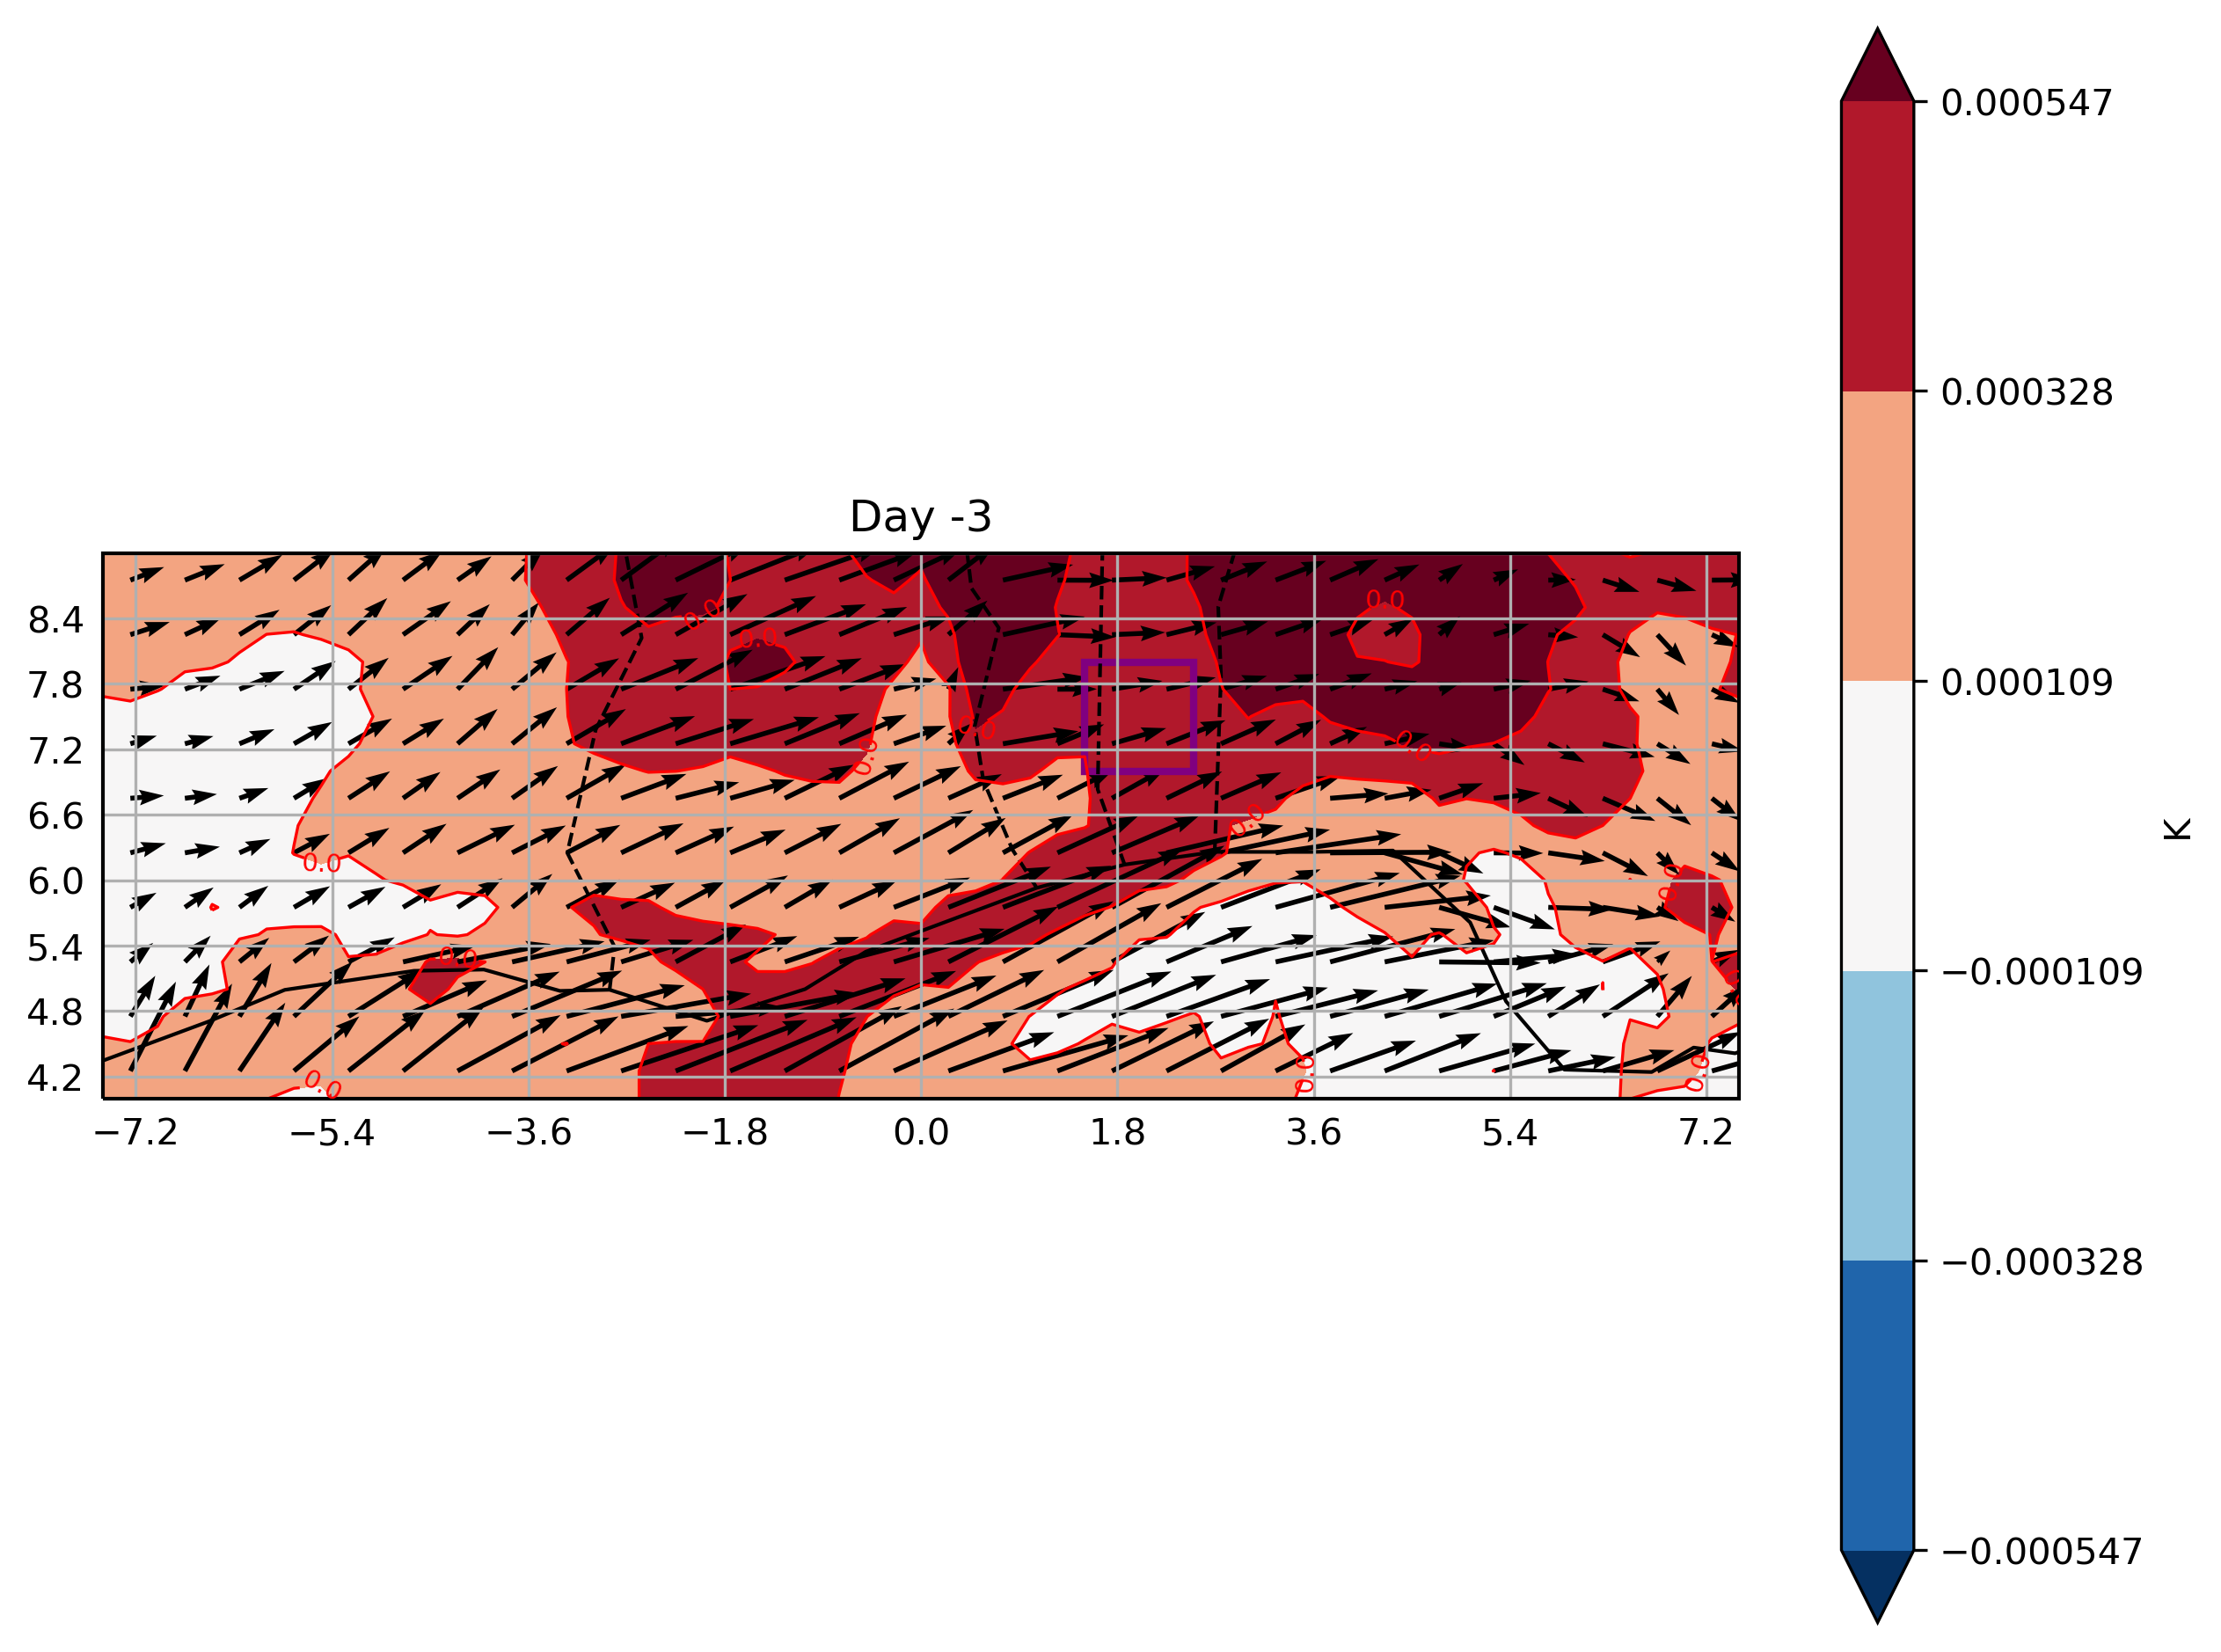

In [232]:
st=2
sarrow = 1
scale = 10
f = plt.figure(figsize=(10,8), dpi=300)

ax = f.add_subplot(111, projection=ccrs.PlateCarree())
lon2d, lat2d = np.meshgrid(lon,lat)
xquiv = lon2d[sarrow::st, sarrow::st]
yquiv = lat2d[sarrow::st, sarrow::st]


ws, wd = u_met.u_v_to_ws_wd(dic['u']-dic['u100'], dic['v']-dic['v100']) 
var = dic['q']
u = dic['u100']
v = dic['v100']
cvar = 'q'
edge = np.max([np.abs(np.percentile(dic[cvar],10)),np.abs(np.percentile(dic[cvar],90))])
levs = np.linspace(edge*-1,edge,6)
contour = {'data' : dic[cvar], 'x': lon, 'y' : lat, 'levels' : levs}

edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
lev = np.linspace(edge*-1,edge,6) #  

uu = u[sarrow::st, sarrow::st]
vv = v[sarrow::st, sarrow::st]
qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
draw_map(ax, var, lat, lon, title='Day -3',  quiver=qin, levels=lev, contour=contour, box=box)

-3
Doing AMSR_20000302.nc
Doing AMSR_20010226.nc
Doing AMSR_20010307.nc
Doing AMSR_20010310.nc
Doing AMSR_20010323.nc
Doing AMSR_20020317.nc
Doing AMSR_20020327.nc
Doing AMSR_20040326.nc
Doing AMSR_20060228.nc
Doing AMSR_20060303.nc
Doing AMSR_20060304.nc
Doing AMSR_20060307.nc
Doing AMSR_20070316.nc
Doing AMSR_20070321.nc
Doing AMSR_20080317.nc
Doing AMSR_20090323.nc
Doing AMSR_20090327.nc
Doing AMSR_20100301.nc
Doing AMSR_20100302.nc
Doing AMSR_20110303.nc
Doing AMSR_20110306.nc
Doing AMSR_20110323.nc
Doing AMSR_20120302.nc
Doing AMSR_20120307.nc
Doing AMSR_20120313.nc
Doing AMSR_20120316.nc
Doing AMSR_20120320.nc
Doing AMSR_20130228.nc
Doing AMSR_20130317.nc
Doing AMSR_20140303.nc
Doing AMSR_20140314.nc
Doing AMSR_20140315.nc
-2
Doing AMSR_20000303.nc
Doing AMSR_20010227.nc
Doing AMSR_20010308.nc
Doing AMSR_20010311.nc
Doing AMSR_20010324.nc
Doing AMSR_20020318.nc
Doing AMSR_20020328.nc
Doing AMSR_20040327.nc
Doing AMSR_20060301.nc
Doing AMSR_20060304.nc
Doing AMSR_20060305.nc
Doing

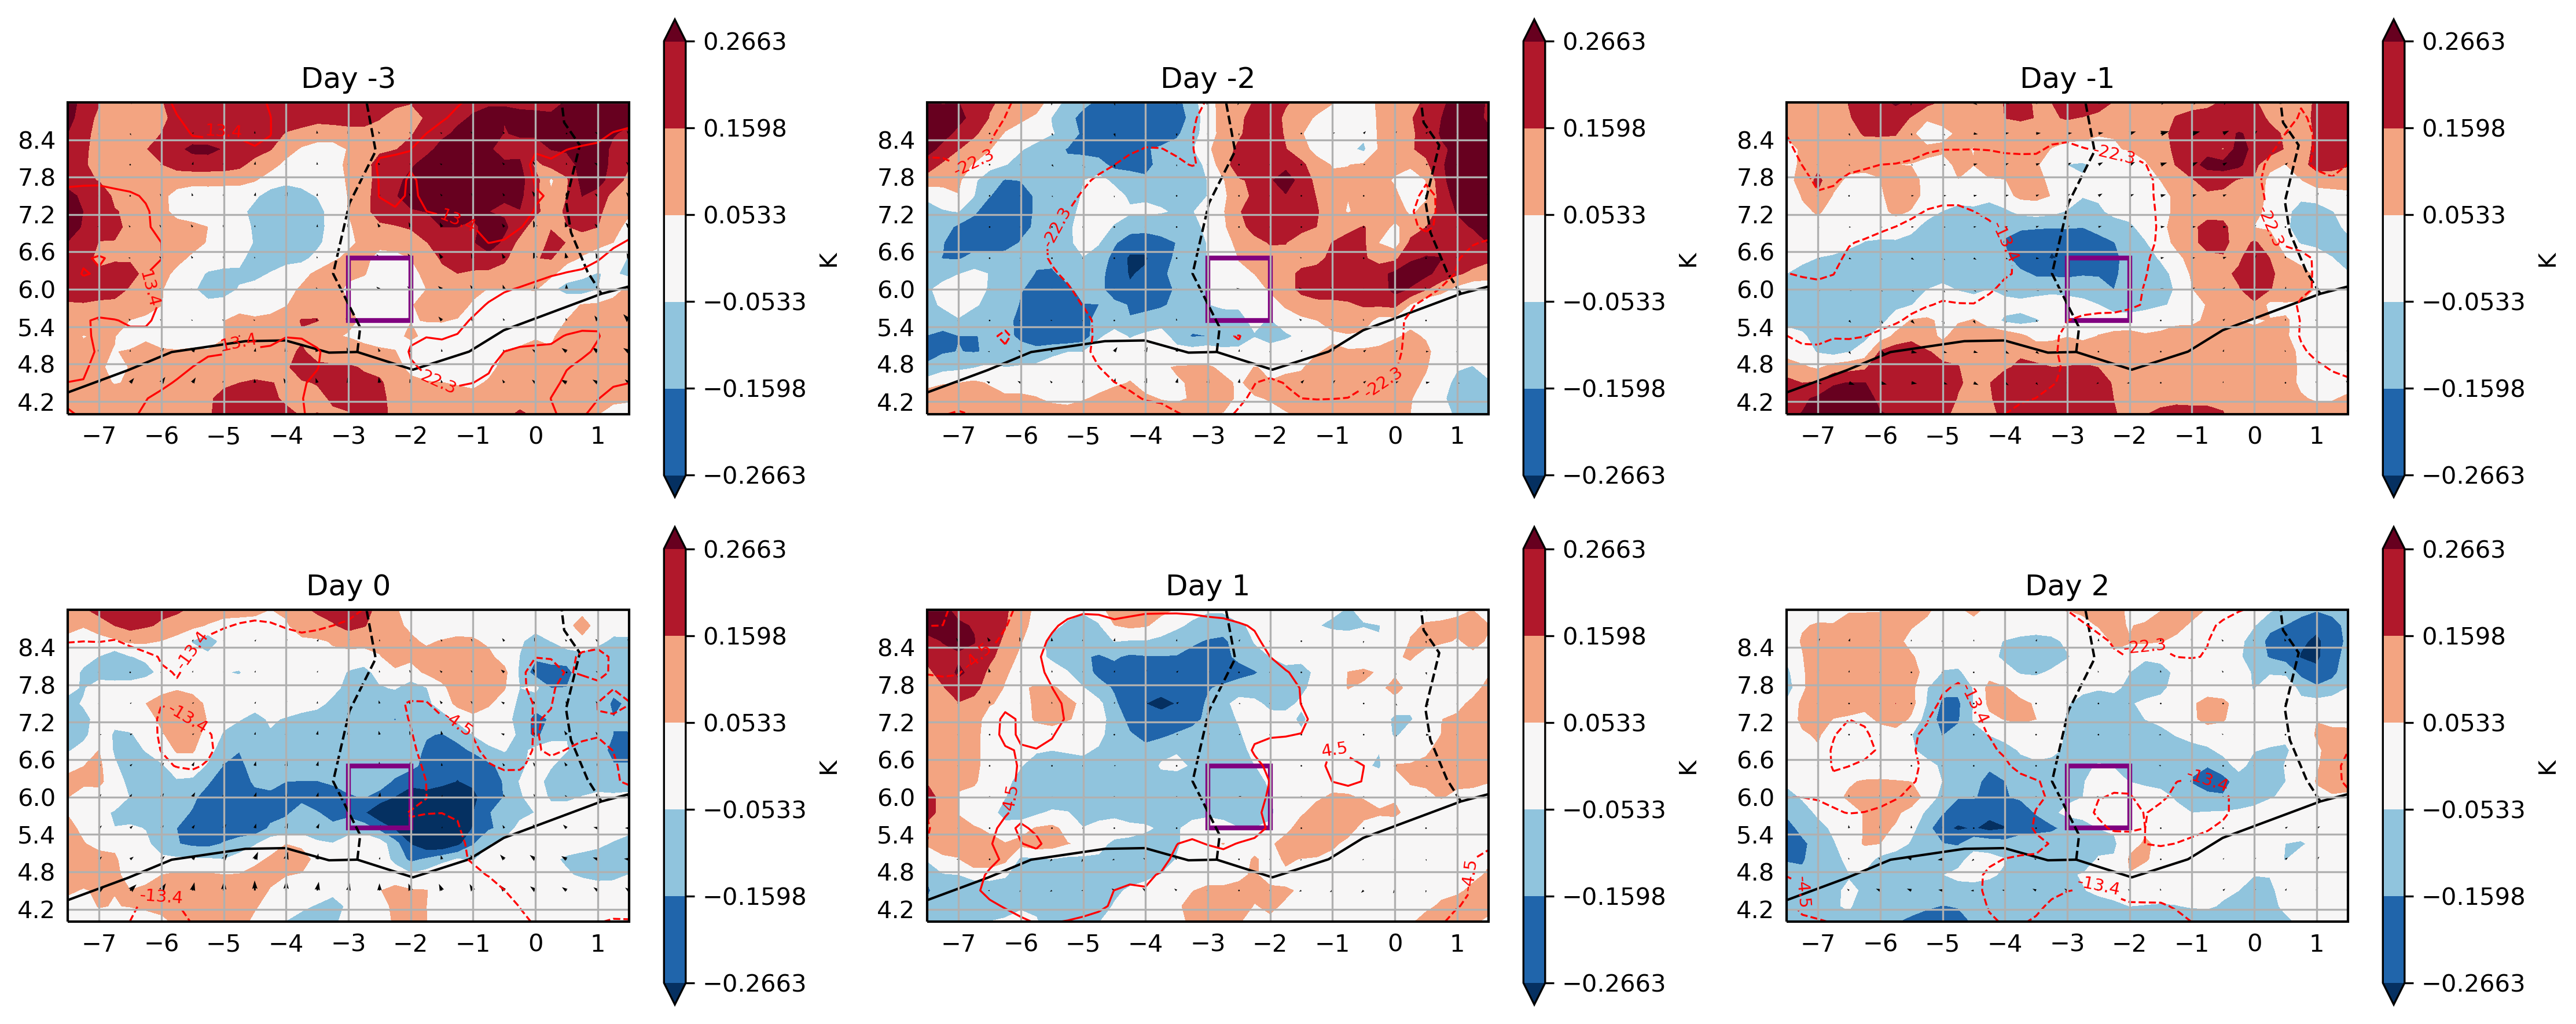

In [173]:
tab = dates_mar
st=2
sarrow = 2
scale = 30
utag = 'u100'
vtag = 'v100'
hour=12
f = plt.figure(figsize=(15,6), dpi=300)

for ids, num in enumerate([-3,-2,-1,0,1,2]):

    ax = f.add_subplot(2,3,ids+1, projection=ccrs.PlateCarree())
    print(num)
    
    dic, lat, lon = run(num, hour, tab)
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    var = dic['t2']
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
        lev = np.linspace(edge*-1,edge,6) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'slp'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,10)),np.abs(np.percentile(invar,90))])
        levs = np.linspace(edge*-1,edge,6) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title='Day '+str(num),  quiver=qin, levels=lev, contour=contour, box=box)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/composites/t2_slp_uv10Ano_march_12UTC.png')

## 